Bankruptcy Prediction Analysis

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [2]:
def clip_to_percentiles(column, min_percentile, max_percentile):
    lower = column.quantile(min_percentile)
    upper = column.quantile(max_percentile)
    return column.clip(lower, upper)

In [3]:
#url = "https://raw.githubusercontent.com/adam-datasci/RiskAnalytics/main/Data/american_bankruptcy.csv?"
url = "Data/american_bankruptcy_normalized.csv"
df = pd.read_csv(url)

In [4]:
features = [
    'wc_to_ta_pct',
    're_to_ta_pct',
    'ebit_to_ta_pct',
    'mv_to_tl_pct',
    'tr_to_ta_pct',
    'tltd_to_te_pct',
    'np_to_tr_pct',
    'ebitda_to_tr_pct',
    'gp_to_tr_pct',
    'ca_to_cl_pct',
    'np_to_ta_pct',
    'default'
    ]


features = [
    'wc_to_ta_pct',
    're_to_ta_pct',
    'ebit_to_ta_pct',
    'mv_to_tl_pct',
    'tr_to_ta_pct',
    'default'
    ]

industries = ['Agriculture','Mining','Construction','Manufacturing','Transportation','Wholesale','Retail','Finance','Services','Public']
industries = ['Manufacturing']

df_filtered = df[df['Division'].isin(industries)]
df_filtered = df_filtered[features]

In [5]:
#for feature in features[:-1]:
 #   df_filtered[feature] = clip_to_percentiles(df[feature],0.05,0.95)

In [6]:
#Create a sample of a specific size for the filtered data
sample_size = 1000
df_filtered_sample = df_filtered.sample(sample_size, random_state=1)

#pull out both the default and non-default periods
default_periods = df_filtered[df['default'] == 1]
non_default_periods = df_filtered[df['default'] == 0]
no_rows = default_periods.shape[0]

#Create a balanced dataset
df_sample_non_default = non_default_periods.sample(no_rows, random_state=1)
df_balanced = pd.concat([default_periods, df_sample_non_default])

X = df_balanced.drop('default', axis=1)
y = df_balanced['default']

C:\Users\adamk\AppData\Local\Temp\ipykernel_24696\1723107776.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default_periods = df_filtered[df['default'] == 1]
C:\Users\adamk\AppData\Local\Temp\ipykernel_24696\1723107776.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_default_periods = df_filtered[df['default'] == 0]


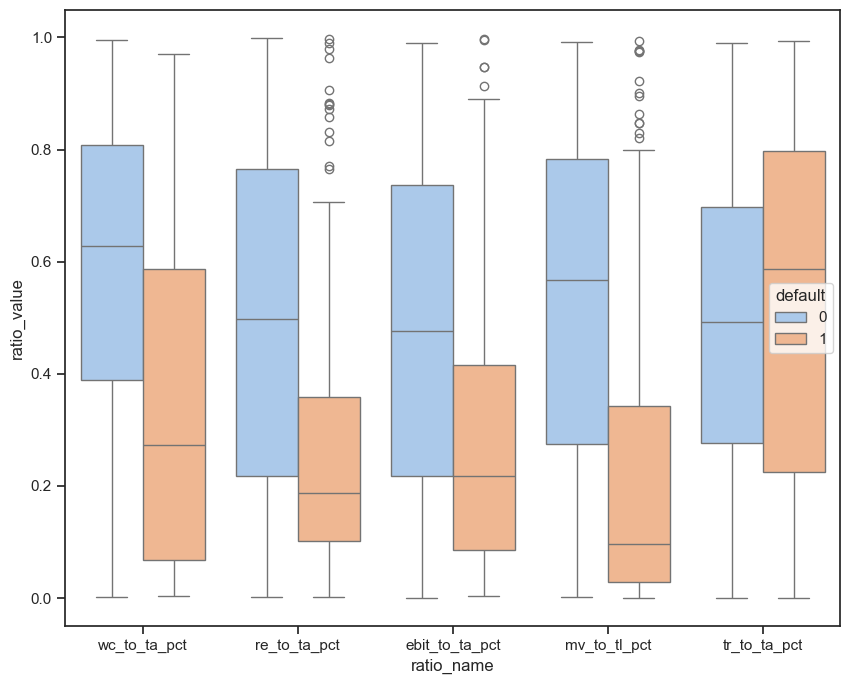

In [7]:
df_filtered_sample_by_status = df_balanced.melt(id_vars='default', value_vars=features[:-1],var_name='ratio_name',value_name='ratio_value')

plt.figure(figsize=(10, 8))
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x='ratio_name', y='ratio_value', hue='default', data=df_filtered_sample_by_status)
plt.show()

In [8]:
#min_max_scaler = MinMaxScaler(feature_range=(0, 1))

#df_balanced = pd.DataFrame(min_max_scaler.fit_transform(df_balanced), columns=df_balanced.columns, index=df_balanced.index)

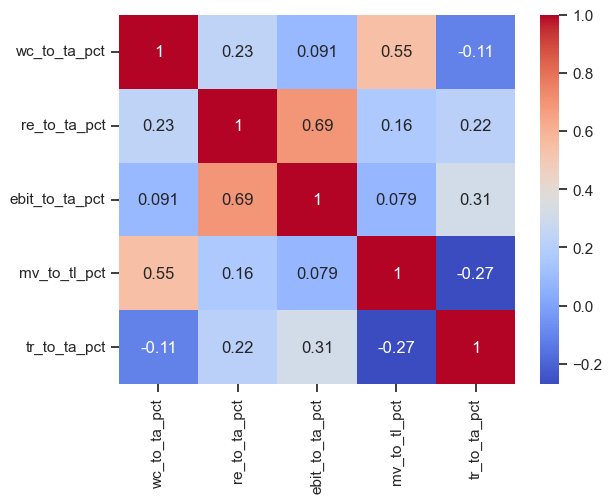

In [9]:
correlation_matrix = X.corr()

# Heatmap of the correlation matrix
dataplot = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [11]:
#Logit Regression
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# SVM
svm_model = SVC(probability=True)  # Enable probability estimate for ROC curve
svm_model.fit(X_train, y_train)

#XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

#predictions_logit = result.predict(X_test)
#predicted_classes_logit = (predictions_logit > 0.5).astype(int)
#model = XGBClassifier(learning_rate =0.1, randon_state=42)
#result = model.fit(X_train,y_train)

Optimization terminated successfully.
         Current function value: 0.550240
         Iterations 6


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
logit_pred = result.predict(X_test)
logit_pred_classes = (logit_pred > 0.5).astype(int)

svm_pred = svm_model.predict_proba(X_test)
svm_pred = svm_pred[:,1]
svm_pred_classes = (svm_pred > 0.5).astype(int)

xgb_pred = xgb_model.predict_proba(X_test)
xgb_pred = xgb_pred[:,1]
xgb_pred_classes = (xgb_pred > 0.5).astype(int)




In [19]:
cm1 = confusion_matrix(y_test, logit_pred_classes)
cm2 = confusion_matrix(y_test, svm_pred_classes)
cm3 = confusion_matrix(y_test, xgb_pred_classes)

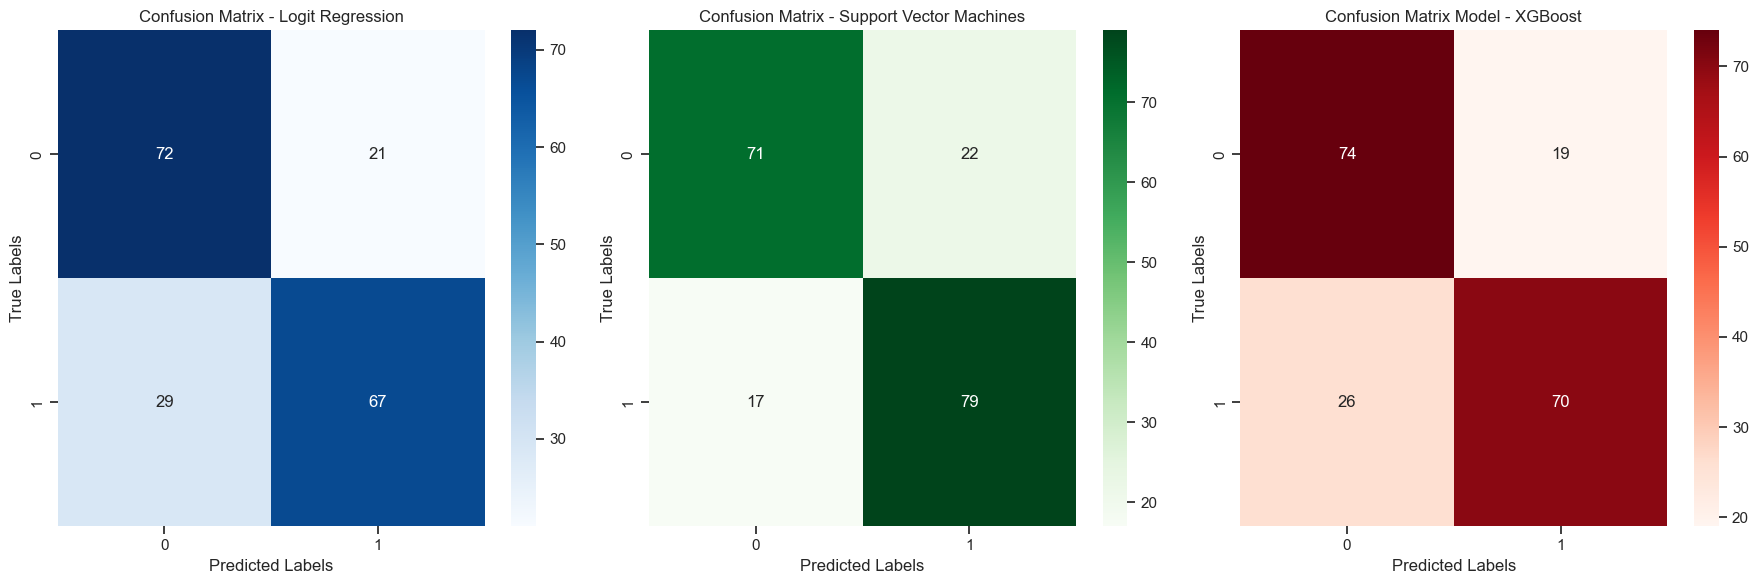

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

sns.heatmap(cm1, annot=True, ax=axes[0], fmt='g', cmap='Blues')
axes[0].set_title('Confusion Matrix - Logit Regression')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(cm2, annot=True, ax=axes[1], fmt='g', cmap='Greens')
axes[1].set_title('Confusion Matrix - Support Vector Machines')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

sns.heatmap(cm3, annot=True, ax=axes[2], fmt='g', cmap='Reds')
axes[2].set_title('Confusion Matrix Model - XGBoost')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

In [ ]:
fpr1, tpr1 = roc_curve(y_test, logit_pred)
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2 = roc_curve(y_test, svm_pred)
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3 = roc_curve(y_test, xgb_pred)
roc_auc3 = auc(fpr3, tpr3)

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  351
Model:                          Logit   Df Residuals:                      346
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Apr 2024   Pseudo R-squ.:                 0.04048
Time:                        16:03:45   Log-Likelihood:                -233.43
converged:                       True   LL-Null:                       -243.28
Covariance Type:            nonrobust   LLR p-value:                 0.0005733
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wc_to_ta       0.0863      0.061      1.414      0.157      -0.033       0.206
re_to_ta      -0.0241      0.010     -2.404      0.016      -0.044      -0.004
ebit_to_ta     0.0711      0.118      0.603      0.547      -0.160       0.302
mv_to_tl      -0.0481      0.017     -2.832      0.005      -0.081      -0.015
tr_to_ta       0.0933      0.083      1.118      0.264      -0.070       0.257
==============================================================================
"""

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Print the coefficients
print("Coefficients:", lda.coef_)

# You can also explore how well it separates the classes
print("Class separation:", lda.explained_variance_ratio_)

Coefficients: [[ 0.02610238 -0.00632761  0.01763914 -0.01971921  0.16991656]]
Class separation: [1.]


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

KeyError: 'key of type tuple not found and not a MultiIndex'